In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import re

In [3]:
plt.rc('font',family = 'malgun gothic')
plt.rcParams['axes.unicode_minus'] = False
warnings.filterwarnings(action = 'ignore')

# 기온,강수량 파생변수 합치기

In [17]:
train = pd.read_csv('C:/Users/whileduck/Desktop/235743_구내식당 식사 인원 예측 AI 경진대회_data (1)/train.csv')
test = pd.read_csv('C:/Users/whileduck/Desktop/235743_구내식당 식사 인원 예측 AI 경진대회_data (1)/test.csv')
기온 = pd.read_csv("C:/Users/whileduck/Desktop/235743_구내식당 식사 인원 예측 AI 경진대회_data (1)/weather.csv", encoding = 'cp949')
강수 = pd.read_csv("C:/Users/whileduck/Desktop/235743_구내식당 식사 인원 예측 AI 경진대회_data (1)/rain.csv", encoding = 'cp949')

In [18]:
기온.head()

,날짜,지점,평균기온(℃),최저기온(℃),최고기온(℃)
0,\t2016-02-01,192.0,-0.6,-4.1,5.0
1,\t2016-02-02,192.0,-2.3,-9.1,6.2
2,\t2016-02-03,192.0,-1.7,-9.3,7.7
3,\t2016-02-04,192.0,-0.2,-7.7,7.7
4,\t2016-02-05,192.0,1.3,-6.5,9.6


* 기온, 강수 출처 : https://data.kma.go.kr/stcs/grnd/grndRnList.do?pgmNo=69

In [19]:
raw_data = pd.concat([train,test])

강수 = 강수.fillna(0)[['날짜','강수량(mm)']]

기온['지점'] = 기온['날짜'].map(lambda x: x[1:])

기온 = 기온[['지점','평균기온(℃)']]

In [20]:
강수 = 강수.rename(columns = {'날짜':'일자'})
기온 = 기온.rename(columns = {'지점':'일자',
                      '평균기온(℃)': '평균기온'})

In [21]:
raw_data = pd.merge(raw_data,강수)
raw_data = pd.merge(raw_data,기온)

In [22]:
raw_data = raw_data[raw_data['일자'] > '2020-01-01'] # 코로나 이후만 보도록 하자 

In [23]:
raw_data['년'] = raw_data['일자'].map(lambda x: int(x.split('-')[0]))
raw_data['월'] = raw_data['일자'].map(lambda x: int(x.split('-')[1]))
raw_data['일'] = raw_data['일자'].map(lambda x: int(x.split('-')[2]))

In [24]:
raw_data = raw_data.drop('조식메뉴',axis = 1)

raw_data.head()

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,중식메뉴,석식메뉴,중식계,석식계,강수량(mm),평균기온,년,월,일
956,2020-01-02,목,2821,255,133,338,0.0,"쌀밥/잡곡밥 (쌀:국내산) 떡국 (우잡뼈,양지:호주산) 제육볶음 (돈육:국내산) 시...","카레라이스 (쌀:국내산,돈육:국내 맑은국 생선까스*탈탈소스 멕시칸샐러드 (스모크...",985.0,362.0,0.0,-0.3,2020,1,2
957,2020-01-03,금,2821,321,186,3,0.0,비빔밥 (쌀:국내산) 미소장국 탕수어 (동태:러시아산) 과일샐러드 마늘쫑무침 ...,쌀밥/잡곡밥 (쌀:국내산) 수제비국 돈육장조림 (돈육:국내산) 실곤약초무침 세발...,635.0,344.0,0.0,0.5,2020,1,3
958,2020-01-06,월,2821,119,203,424,5.0,쌀밥/잡곡밥 (쌀:국내산) 된장찌개 돈육김치볶음 사각어묵볶음 쫑상추무침 포기...,쌀밥/잡곡밥 (쌀:국내산) 열무된장국 해물누룽지탕 모듬소시지구이 미역레몬초무침...,1133.0,389.0,13.8,3.1,2020,1,6
959,2020-01-07,화,2821,95,204,448,7.0,쌀밥/잡곡밥 (쌀:국내산) 미역국 순살파닭 감자채전 오이도라지무침 포기김치 ...,참치주먹밥 (쌀:국내산) 우동 새우까스*칠리소스 고구마샐러드 단무지무침 포기...,904.0,490.0,40.3,9.9,2020,1,7
960,2020-01-08,수,2821,117,222,7,5.0,곤드레밥*양념장 (쌀:국내산) 맑은국 돈육강정 (돈육:국내산) 사과고구마그라탕 ...,쌀밥/잡곡밥 (쌀:국내산) 소고기무국 주꾸미볶음 계란찜 애호박나물 포기김치 ...,740.0,321.0,0.0,7.4,2020,1,8


In [25]:
공휴일_전날 =  {
    '2020-01-23': '설날(구정)',
    '2020-01-24': '설날(구정)',
    '2020-01-25': '설날(구정)',
    '2020-02-28': '3·1절',
    '2020-04-29': '부처님 오신 날',
    '2020-05-04': '어린이날',
    '2020-06-05': '현충일',
    '2020-08-14': '광복절',
    '2020-09-29': '추석',
    '2020-10-01': '추석',
    '2020-10-02': '추석',
    '2020-10-03': '개천절',
    '2020-10-08': '한글날',
    '2020-12-24': '크리스마스',
    "2021-12-31": "신정",
    "2021-02-10": "설날",
    "2021-02-11": "설날",
    "2021-02-12": "설날",
    "2021-02-28": "삼일절",
    "2021-05-04": "어린이날",
    "2021-05-18": "부처님오신날",
    "2021-06-05": "현충일",
    "2021-08-14": "광복절",
    "2021-09-19": "추석",
    "2021-09-20": "추석",
    "2021-09-21": "추석",
    "2021-10-02": "개천절",
    "2021-10-08": "한글날",
    "2021-12-24": "크리스마스"
}


In [26]:
전날 = {}
for i in 공휴일_전날.keys():
    
    전날[i] = 1

In [27]:
raw_data['공휴일_전날'] = raw_data['일자'].map(전날).fillna(0).astype(int)

In [28]:
raw_data.loc[raw_data['요일'] == '금','공휴일_전날'] = 1

In [29]:
raw_data.head()

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,중식메뉴,석식메뉴,중식계,석식계,강수량(mm),평균기온,년,월,일,공휴일_전날
956,2020-01-02,목,2821,255,133,338,0.0,"쌀밥/잡곡밥 (쌀:국내산) 떡국 (우잡뼈,양지:호주산) 제육볶음 (돈육:국내산) 시...","카레라이스 (쌀:국내산,돈육:국내 맑은국 생선까스*탈탈소스 멕시칸샐러드 (스모크...",985.0,362.0,0.0,-0.3,2020,1,2,0
957,2020-01-03,금,2821,321,186,3,0.0,비빔밥 (쌀:국내산) 미소장국 탕수어 (동태:러시아산) 과일샐러드 마늘쫑무침 ...,쌀밥/잡곡밥 (쌀:국내산) 수제비국 돈육장조림 (돈육:국내산) 실곤약초무침 세발...,635.0,344.0,0.0,0.5,2020,1,3,1
958,2020-01-06,월,2821,119,203,424,5.0,쌀밥/잡곡밥 (쌀:국내산) 된장찌개 돈육김치볶음 사각어묵볶음 쫑상추무침 포기...,쌀밥/잡곡밥 (쌀:국내산) 열무된장국 해물누룽지탕 모듬소시지구이 미역레몬초무침...,1133.0,389.0,13.8,3.1,2020,1,6,0
959,2020-01-07,화,2821,95,204,448,7.0,쌀밥/잡곡밥 (쌀:국내산) 미역국 순살파닭 감자채전 오이도라지무침 포기김치 ...,참치주먹밥 (쌀:국내산) 우동 새우까스*칠리소스 고구마샐러드 단무지무침 포기...,904.0,490.0,40.3,9.9,2020,1,7,0
960,2020-01-08,수,2821,117,222,7,5.0,곤드레밥*양념장 (쌀:국내산) 맑은국 돈육강정 (돈육:국내산) 사과고구마그라탕 ...,쌀밥/잡곡밥 (쌀:국내산) 소고기무국 주꾸미볶음 계란찜 애호박나물 포기김치 ...,740.0,321.0,0.0,7.4,2020,1,8,0


# 현재 근무자 수 파생 변수 만들기 

In [30]:
raw_data['현재근무자수'] = raw_data['본사정원수'] - raw_data['본사휴가자수'] - raw_data['본사출장자수'] - raw_data['본사시간외근무명령서승인건수'] - raw_data['현본사소속재택근무자수']  

In [31]:
pattern = r'[^\s()]+|\([^)]*\)'

raw_data['중식메뉴'] = raw_data['중식메뉴'].str.findall(pattern).apply(lambda x: [i for i in x if not re.match(r'\(.*\)', i)])
raw_data['석식메뉴'] = raw_data['석식메뉴'].str.findall(pattern).apply(lambda x: [i for i in x if not re.match(r'\(.*\)', i)])

In [32]:
raw_data['중식메뉴갯수'] = [len(x) for x in raw_data['중식메뉴']]
raw_data['석식메뉴갯수'] = [len(x) for x in raw_data['석식메뉴']]

In [33]:
def nyamnyam(x):
    
    밥 = []
    국 = []
    메인 = []
    
    if len(x) >= 3:
        밥.append(x[0])
        국.append(x[1])
        메인.append(x[2])
    if len(x) <= 2:
        밥.append(x[0])
        국.append(x[0])
        메인.append('없음')
    if len(x) == 1:
        밥.append(x[0])
        국.append('없음')
        메인.append('없음')
        
    return {'밥':밥,'국':국,'메인':메인}

In [34]:
중식메뉴 = raw_data['중식메뉴'].map(nyamnyam)
석식메뉴 = raw_data['석식메뉴'].map(nyamnyam)

# raw_data['중식밥'] = 중식메뉴[]

In [35]:
중식_밥 = []
중식_국 = []
중식_메인 = []

석식_밥 = []
석식_국 = []
석식_메인 = []
for i in 중식메뉴:
    
    중식_밥.append(i['밥'])
    중식_국.append(i['국'])
    중식_메인.append(i['메인'])
    
for i in 석식메뉴:
    
    석식_밥.append(i['밥'])
    석식_국.append(i['국'])
    석식_메인.append(i['메인'])

In [36]:
raw_data['중식_밥'] = 중식_밥
raw_data['중식_국'] = 중식_국
raw_data['중식_메인'] = 중식_메인

raw_data['석식_밥'] = 석식_밥
raw_data['석식_국'] = 석식_국
raw_data['석식_메인'] = 석식_메인

In [37]:
raw_data = raw_data.drop(['중식메뉴','석식메뉴'],axis = 1)
raw_data.head()

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,중식계,석식계,강수량(mm),...,공휴일_전날,현재근무자수,중식메뉴갯수,석식메뉴갯수,중식_밥,중식_국,중식_메인,석식_밥,석식_국,석식_메인
956,2020-01-02,목,2821,255,133,338,0.0,985.0,362.0,0.0,...,0,2095.0,7,3,[쌀밥/잡곡밥],[떡국],[제육볶음],[카레라이스],[오복지무침],[포기김치]
957,2020-01-03,금,2821,321,186,3,0.0,635.0,344.0,0.0,...,1,2311.0,6,6,[비빔밥],[미소장국],[탕수어],[쌀밥/잡곡밥],[수제비국],[돈육장조림]
958,2020-01-06,월,2821,119,203,424,5.0,1133.0,389.0,13.8,...,0,2070.0,6,6,[쌀밥/잡곡밥],[된장찌개],[돈육김치볶음],[쌀밥/잡곡밥],[열무된장국],[해물누룽지탕]
959,2020-01-07,화,2821,95,204,448,7.0,904.0,490.0,40.3,...,0,2067.0,6,6,[쌀밥/잡곡밥],[미역국],[순살파닭],[참치주먹밥],[우동],[새우까스*칠리소스]
960,2020-01-08,수,2821,117,222,7,5.0,740.0,321.0,0.0,...,0,2470.0,6,6,[곤드레밥*양념장],[맑은국],[돈육강정],[쌀밥/잡곡밥],[소고기무국],[주꾸미볶음]


* 메뉴에서 특수기호를 제거하자 

In [38]:
cols = [ '중식_밥', '중식_국', '중식_메인', '석식_밥', '석식_국',
        '석식_메인']

for col in cols:
    
    raw_data[col] = raw_data[col].map(lambda x:x[0])

In [39]:
def boglebogle(x,menu):
    
    if menu.endswith('밥'):
        
        if x.startswith('쌀'):
            return '쌀밥'
        else:
            return '특식'
        
    if menu.endswith('국'):
        
        if x.endswith('국'):
            return '국'
        if x.endswith('탕'):
            return '탕'
        if x.endswith('찌개'):
            return '찌개'
        else:
            return '특식'

In [40]:
cols = [ '중식_밥', '중식_국',  '석식_밥', '석식_국']

for col in cols:
    
    for i in range(len(raw_data)):
        
        raw_data[col].iloc[i] = boglebogle(raw_data[col].iloc[i],col)

In [41]:
words = {
    '돼지': ['춘권','햄','도시락','제육','오향장육','류산슬','핫도그','등뼈','자장','미트','산적','소떡','만두','꿔바로우','돈','돈육', '삼겹살', '목살', '항정살', '갈비', '꽃등심', '두루치기', '보쌈', '훈제', '고기전골', '족발','돼지',
            '너비아니','짜장','딤섬','깐풍기','탕수육','바베큐','불고기','완자','대패','카츠','깐풍','삼겹','퀘사디아'],
    '소': ['사골','쇠','소고기', '갈비살', '양지머리','육전','양지불고기','스테이크', '차돌박이', '등심', '안심', '사태', '양념갈비', '국밥', '철판볶음밥','소갈비'],
    '닭': ['닭가슴살','궁보계정','장각','코코뱅', '치킨','교촌', '양념치킨', '후라이드', '간장치킨', '치즈볼', '날치알볶음밥', '떡볶이', '닭볶음탕', '삶은달걀', '샐러드','닭','유린'],
    '해산물': ['생선','꽁치','해물','새우','홍어','코다리','주꾸미','쭈꾸미','굴비','멘보샤',
            '골뱅이','적어','참치','방어','낙지','날＞','어묵','오징어', '꽃게', '동태','꽁채','동파육','홍합','조기', '멍게','양장피',
            '아귀','갈치','열기어','게장', '장어', '가자미', '전복죽','고등어','꽁치','삼치', '광어회', '연어덮밥','탕수어'],
    '오리' : ['오리'],
    '채소' : ['두부','고구마','고추잡채','메밀','고추튀김','또띠아','가지','순대','가지','김말이','생야채','사라다','포기','팽이','채소','쌈추','양송이',
            '부추전','고로케','브로콜리','깻잎','양파링','부추고추전','된장'],
    '면' : ['우동','페스토','알리오','파스타','스파게티','국수','라볶이','쫄면'],
    '피자' :['피자','가래떡'],
    '없음' : ['없음']
}


중식_메인 = {}
for key,values in words.items():
    for value in values:
        for word in raw_data['중식_메인'].unique():
            if value in word:
                
                중식_메인[word] = key
                

석식_메인 = {}

for key,values in words.items():
    for value in values:
        for word in raw_data['석식_메인'].unique():
            if value in word:
                
                석식_메인[word] = key

In [42]:
raw_data['중식_메인'] = raw_data['중식_메인'].map(중식_메인)
raw_data['석식_메인'] = raw_data['석식_메인'].map(석식_메인)

In [43]:
raw_data['요일'] = raw_data['요일'].map({'월':0, '화':1,'수':2,'목':3,'금':4})

In [44]:
raw_data.head()

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,중식계,석식계,강수량(mm),...,공휴일_전날,현재근무자수,중식메뉴갯수,석식메뉴갯수,중식_밥,중식_국,중식_메인,석식_밥,석식_국,석식_메인
956,2020-01-02,3,2821,255,133,338,0.0,985.0,362.0,0.0,...,0,2095.0,7,3,쌀밥,국,돼지,특식,특식,채소
957,2020-01-03,4,2821,321,186,3,0.0,635.0,344.0,0.0,...,1,2311.0,6,6,특식,국,해산물,쌀밥,국,돼지
958,2020-01-06,0,2821,119,203,424,5.0,1133.0,389.0,13.8,...,0,2070.0,6,6,쌀밥,찌개,돼지,쌀밥,국,해산물
959,2020-01-07,1,2821,95,204,448,7.0,904.0,490.0,40.3,...,0,2067.0,6,6,쌀밥,국,닭,특식,특식,해산물
960,2020-01-08,2,2821,117,222,7,5.0,740.0,321.0,0.0,...,0,2470.0,6,6,특식,국,돼지,쌀밥,국,해산물


In [45]:
raw_data.to_csv('raw_data.csv',index = False)

* 전처리는 끝났으니 EDA 하자 

In [46]:
raw_data

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,중식계,석식계,강수량(mm),...,공휴일_전날,현재근무자수,중식메뉴갯수,석식메뉴갯수,중식_밥,중식_국,중식_메인,석식_밥,석식_국,석식_메인
956,2020-01-02,3,2821,255,133,338,0.0,985.0,362.0,0.0,...,0,2095.0,7,3,쌀밥,국,돼지,특식,특식,채소
957,2020-01-03,4,2821,321,186,3,0.0,635.0,344.0,0.0,...,1,2311.0,6,6,특식,국,해산물,쌀밥,국,돼지
958,2020-01-06,0,2821,119,203,424,5.0,1133.0,389.0,13.8,...,0,2070.0,6,6,쌀밥,찌개,돼지,쌀밥,국,해산물
959,2020-01-07,1,2821,95,204,448,7.0,904.0,490.0,40.3,...,0,2067.0,6,6,쌀밥,국,닭,특식,특식,해산물
960,2020-01-08,2,2821,117,222,7,5.0,740.0,321.0,0.0,...,0,2470.0,6,6,특식,국,돼지,쌀밥,국,해산물
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1250,2021-04-05,0,2973,125,174,704,331.0,NaN,NaN,0.0,...,0,1639.0,7,6,쌀밥,국,닭,특식,찌개,해산물
1251,2021-04-06,1,2973,76,170,636,364.0,NaN,NaN,0.0,...,0,1727.0,7,6,쌀밥,탕,소,특식,특식,돼지
1252,2021-04-07,2,2973,96,214,1,334.0,NaN,NaN,0.0,...,0,2328.0,7,6,쌀밥,국,돼지,특식,국,돼지
1253,2021-04-08,3,2973,105,238,509,324.0,NaN,NaN,0.0,...,0,1797.0,7,6,쌀밥,국,닭,특식,탕,소


In [47]:
train = raw_data[raw_data['일자'] < '2021-01-27']  # dataset 분리
test = raw_data[raw_data['일자'] >= '2021-01-27']

In [48]:
df = train.copy()

# 시계열로 보는 중식계, 석식계 

Text(0.5, 0.98, '일자별 중식계, 석식계 변화')

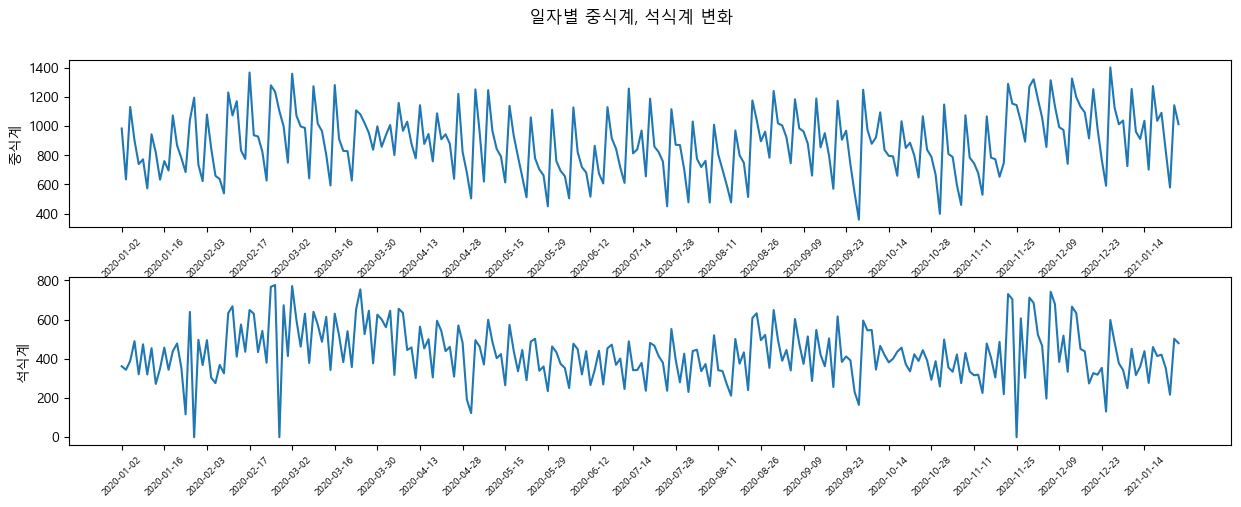

In [49]:
fit,ax = plt.subplots(nrows = 2, figsize = [15,5])
plt.subplots_adjust(hspace = 0.3)

ax = ax.flatten()

sns.lineplot(data = df,
            x = '일자',
            y = '중식계',
            ax = ax[0])

ax[0].set_title('일자 별 중식계')
ax[0].set_xticks(df['일자'][::10])
ax[0].set_xticklabels(df['일자'][::10], rotation = 45, fontsize = 7)
ax[0].set_xlabel('')
ax[0].set_title('')

sns.lineplot(data = df,
            x = '일자',
            y = '석식계',
            ax = ax[1])

ax[1].set_title('일자 별 석식계')
ax[1].set_xticks(df['일자'][::10])
ax[1].set_xticklabels(df['일자'][::10],rotation = 45, fontsize = 7)
ax[1].set_xlabel('')
ax[1].set_title('')

plt.suptitle('일자별 중식계, 석식계 변화')

* 확실히 어떤 패턴 별로 있는 것을 알 수 있다.

* 아마도 요일별이거나, 공휴일 전일인지 아닌지에 따라 다른듯 하다. 

* 일자별 데이터를 공휴일 전, 후로 해서 비교해보자 

Text(0.5, 0.98, '평일, 공휴일 전날의 중식계, 석식계 차이')

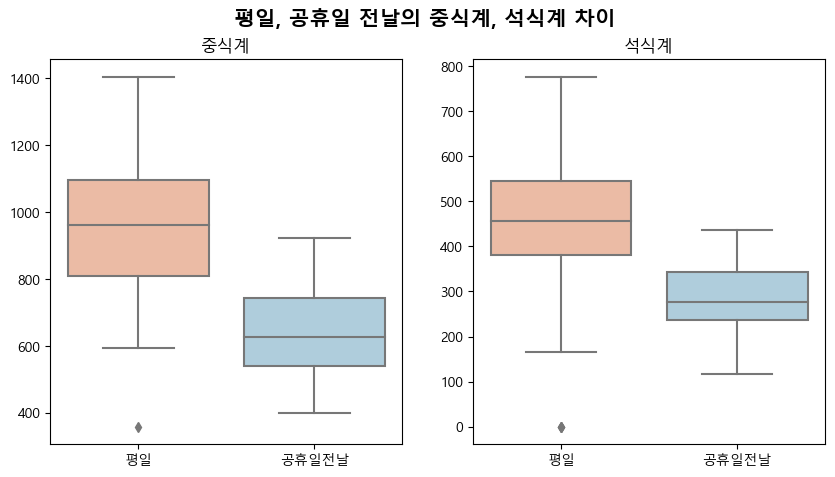

In [50]:
# 공휴일 전날과 아닌 날의 식사량 비교 

fig,ax = plt.subplots(ncols = 2,figsize = (10,5))

sns.boxplot(data = df,
            x = '공휴일_전날',
            y = '중식계',
            ax = ax[0],
            palette = "RdBu")

ax[0].set_xticklabels(['평일','공휴일전날'])
ax[0].set_xlabel('')
ax[0].set_ylabel('')
ax[0].set_title('중식계')
sns.boxplot(data = df,
            x = '공휴일_전날',
            y = '석식계',
            ax = ax[1],
            palette = "RdBu")

ax[1].set_xticklabels(['평일','공휴일전날'])
ax[1].set_xlabel('')
ax[1].set_ylabel('')
ax[1].set_title('석식계')

plt.suptitle('평일, 공휴일 전날의 중식계, 석식계 차이',weight = 'bold',fontsize = 15)

* 요일별로는 다를까?

Text(0.5, 0.98, '요일 별 중식계, 석식계 차이')

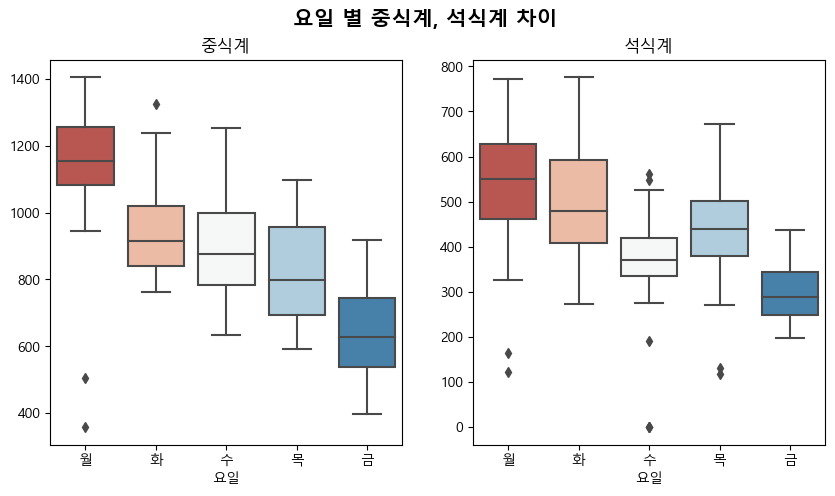

In [51]:
fig,ax = plt.subplots(ncols = 2,figsize = (10,5))

sns.boxplot(data = df,
            x = '요일',
            y = '중식계',
            ax = ax[0],
            palette = "RdBu")

ax[0].set_xticklabels(['월','화','수','목','금'])
ax[0].set_ylabel('')
ax[0].set_title('중식계')

sns.boxplot(data = df,
            x = '요일',
            y = '석식계',
            ax = ax[1],
            palette = "RdBu")

ax[1].set_xticklabels(['월','화','수','목','금'])
ax[1].set_ylabel('')
ax[1].set_title('석식계')

plt.suptitle('요일 별 중식계, 석식계 차이',weight = 'bold',fontsize = 15)

# 날씨와는 어떨까

Text(0.5, 0.98, '평균기온 별 중식계, 석식계 차이')

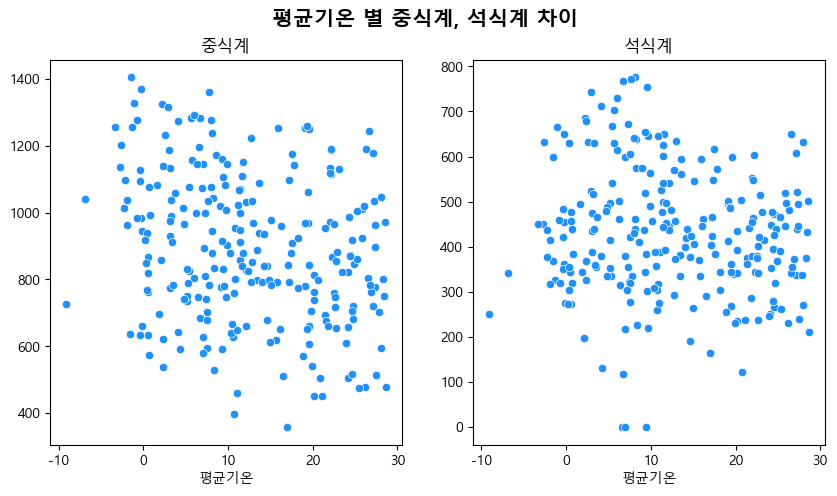

In [52]:
fig,ax = plt.subplots(ncols = 2,figsize = (10,5))

sns.scatterplot(data = df,
            x = '평균기온',
            y = '중식계',
            ax = ax[0],
            color = 'dodgerblue')

ax[0].set_ylabel('')
ax[0].set_title('중식계')


sns.scatterplot(data = df,
            x = '평균기온',
            y = '석식계',
            ax = ax[1],
            color = "dodgerblue")
ax[1].set_ylabel('')
ax[1].set_title('석식계')


plt.suptitle('평균기온 별 중식계, 석식계 차이',weight = 'bold',fontsize = 15)

Text(0.5, 0.98, '강수량 별 중식계, 석식계 차이')

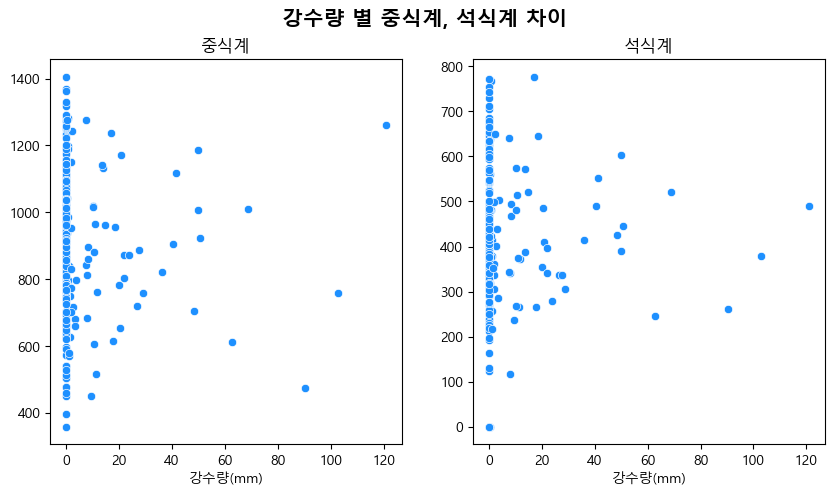

In [53]:
fig,ax = plt.subplots(ncols = 2,figsize = (10,5))

sns.scatterplot(data = df,
            x = '강수량(mm)',
            y = '중식계',
            ax = ax[0],
            color = 'dodgerblue')
ax[0].set_ylabel('')
ax[0].set_title('중식계')

sns.scatterplot(data = df,
            x = '강수량(mm)',
            y = '석식계',
            ax = ax[1],
            color = 'dodgerblue')
ax[1].set_ylabel('')
ax[1].set_title('석식계')

plt.suptitle('강수량 별 중식계, 석식계 차이', weight = 'bold',fontsize = 15)

* 날씨와는 그닥 상관이 없는 것 같다.

# 메뉴와는 어떨까

Text(0.5, 0.98, '밥 메뉴 별 중식계, 석식계 차이')

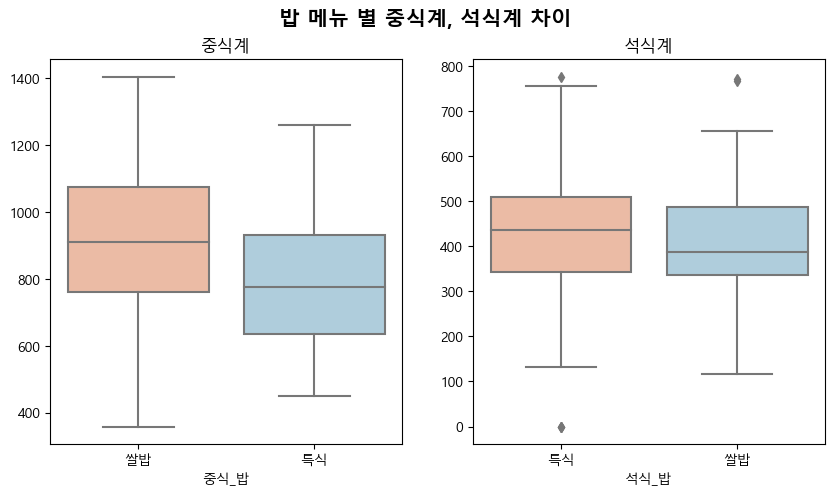

In [54]:

fig,ax = plt.subplots(ncols = 2,figsize = (10,5))

sns.boxplot(data = df,
            x = '중식_밥',
            y = '중식계',
            ax = ax[0],
            palette = "RdBu")
ax[0].set_ylabel('')
ax[0].set_title('중식계')

sns.boxplot(data = df,
            x = '석식_밥',
            y = '석식계',
            ax = ax[1],
            palette = "RdBu")
ax[1].set_ylabel('')
ax[1].set_title('석식계')


plt.suptitle('밥 메뉴 별 중식계, 석식계 차이',weight = 'bold',fontsize = 15)

Text(0.5, 0.98, '국 메뉴 별 중식계, 석식계 차이')

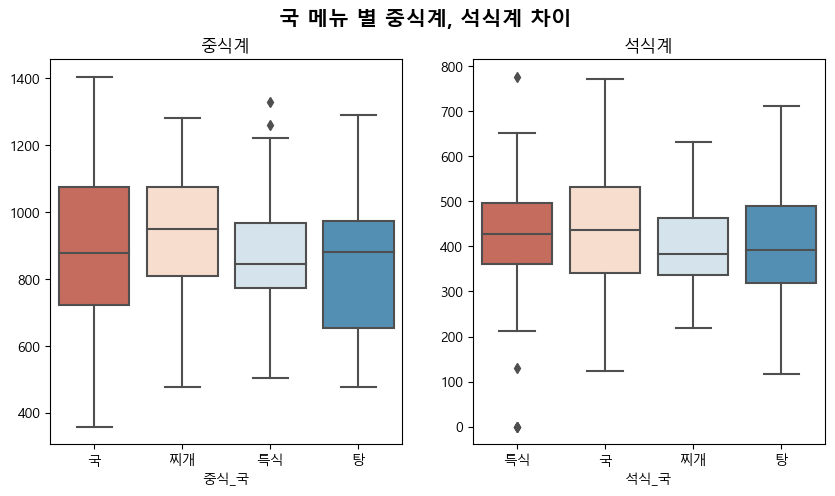

In [55]:
fig,ax = plt.subplots(ncols = 2,figsize = (10,5))

sns.boxplot(data = df,
            x = '중식_국',
            y = '중식계',
            ax = ax[0],
            palette = "RdBu")
ax[0].set_ylabel('')
ax[0].set_title('중식계')

sns.boxplot(data = df,
            x = '석식_국',
            y = '석식계',
            ax = ax[1],
            palette = "RdBu")

ax[1].set_ylabel('')
ax[1].set_title('석식계')


plt.suptitle('국 메뉴 별 중식계, 석식계 차이',weight = 'bold',fontsize = 15)

Text(0.5, 0.98, '메인 메뉴 별 중식계, 석식계 차이')

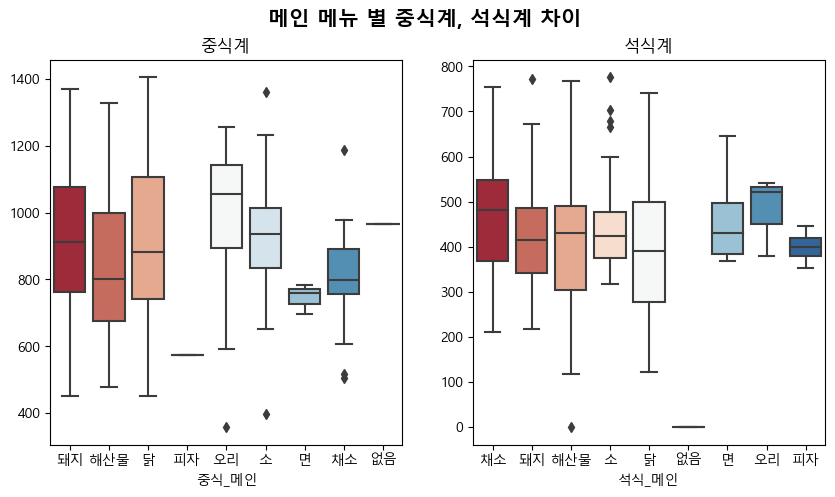

In [56]:
fig,ax = plt.subplots(ncols = 2,figsize = (10,5))

sns.boxplot(data = df,
            x = '중식_메인',
            y = '중식계',
            ax = ax[0],
            palette = "RdBu")
ax[0].set_ylabel('')
ax[0].set_title('중식계')

sns.boxplot(data = df,
            x = '석식_메인',
            y = '석식계',
            ax = ax[1],
            palette = "RdBu")
ax[1].set_ylabel('')
ax[1].set_title('석식계')

plt.suptitle('메인 메뉴 별 중식계, 석식계 차이', weight = 'bold', fontsize = 15)

Text(0.5, 0.98, '메뉴 갯수 별 중식계, 석식계 차이')

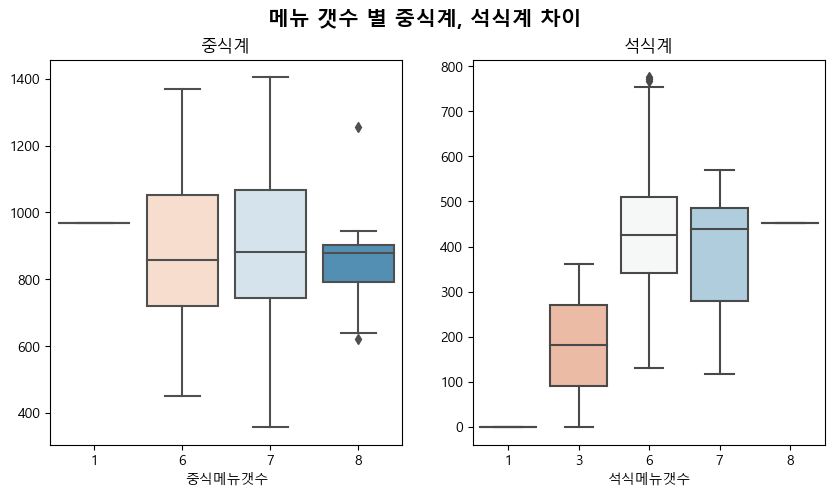

In [57]:
fig,ax = plt.subplots(ncols = 2,figsize = (10,5))

sns.boxplot(data = df,
            x = '중식메뉴갯수',
            y = '중식계',
            ax = ax[0],
            palette = "RdBu")
ax[0].set_ylabel('')
ax[0].set_title('중식계')

sns.boxplot(data = df,
            x = '석식메뉴갯수',
            y = '석식계',
            ax = ax[1],
            palette = "RdBu")
ax[1].set_ylabel('')
ax[1].set_title('석식계')

plt.suptitle('메뉴 갯수 별 중식계, 석식계 차이', weight = 'bold',fontsize = 15)

# 회사 정보에 따라선 어떨까 

* 음의 상관관계가 있다.

Text(0, 0.5, '')

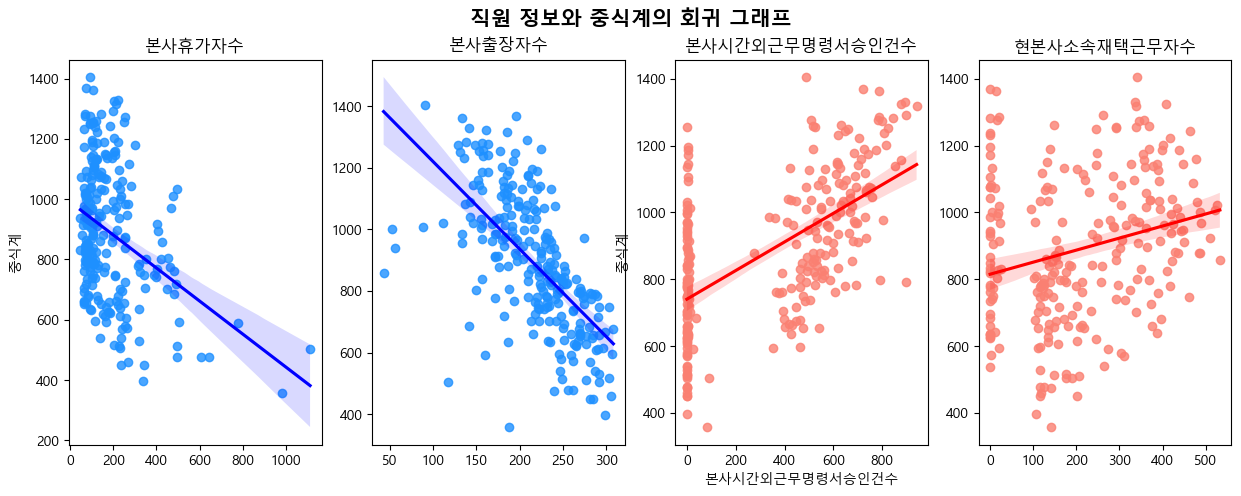

In [58]:
plt.figure(figsize = [15,5])

plt.subplot(1,4,1)

sns.regplot(data = df,
            x = '본사휴가자수',
            y = '중식계',
            scatter_kws = {'color':'dodgerblue'},
            line_kws = {'color':'blue'})
plt.title('본사휴가자수')
plt.xlabel('')
plt.ylabel('중식계')
plt.subplot(1,4,2)

sns.regplot(data = df,
            x = '본사출장자수',
            y = '중식계',
            scatter_kws = {'color':'dodgerblue'},
            line_kws = {'color':'blue'})
plt.title('본사출장자수')

plt.xlabel('')
plt.ylabel('')
plt.subplot(1,4,3)

sns.regplot(data = df,
            x = '본사시간외근무명령서승인건수',
            y = '중식계',
            scatter_kws = {'color':'salmon'},
            line_kws = {'color':'red'})
plt.title('본사시간외근무명령서승인건수')
plt.suptitle('직원 정보와 중식계의 회귀 그래프',fontsize = 15,
             weight = 'bold')

plt.subplot(1,4,4)
sns.regplot(data = df,
            x = '현본사소속재택근무자수',
            y = '중식계',
            scatter_kws = {'color':'salmon'},
            line_kws = {'color':'red'})
plt.title('현본사소속재택근무자수')
plt.suptitle('직원 정보와 중식계의 회귀 그래프',fontsize = 15,
             weight = 'bold')

plt.xlabel('')
plt.ylabel('')

Text(0, 0.5, '')

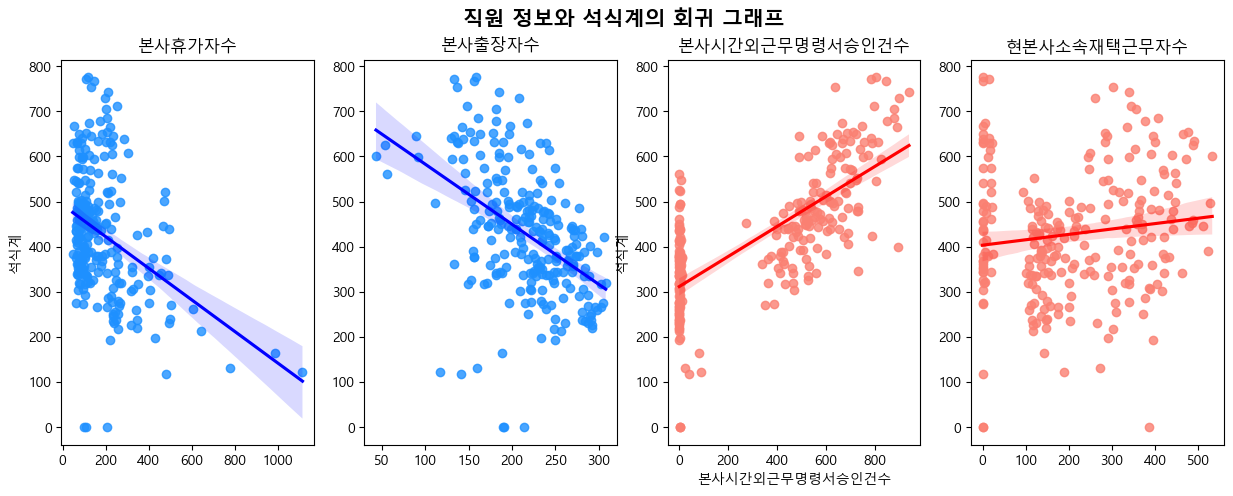

In [59]:
plt.figure(figsize = [15,5])

plt.subplot(1,4,1)

sns.regplot(data = df,
            x = '본사휴가자수',
            y = '석식계',
            scatter_kws = {'color':'dodgerblue'},
            line_kws = {'color':'blue'})
plt.title('본사휴가자수')
plt.xlabel('')
plt.ylabel('석식계')
plt.subplot(1,4,2)

sns.regplot(data = df,
            x = '본사출장자수',
            y = '석식계',
            scatter_kws = {'color':'dodgerblue'},
            line_kws = {'color':'blue'})
plt.title('본사출장자수')

plt.xlabel('')
plt.ylabel('')
plt.subplot(1,4,3)

sns.regplot(data = df,
            x = '본사시간외근무명령서승인건수',
            y = '석식계',
            scatter_kws = {'color':'salmon'},
            line_kws = {'color':'red'})
plt.title('본사시간외근무명령서승인건수')
plt.suptitle('직원 정보와 석식계의 회귀 그래프',fontsize = 15,
             weight = 'bold')

plt.subplot(1,4,4)
sns.regplot(data = df,
            x = '현본사소속재택근무자수',
            y = '석식계',
            scatter_kws = {'color':'salmon'},
            line_kws = {'color':'red'})
plt.title('현본사소속재택근무자수')
plt.suptitle('직원 정보와 석식계의 회귀 그래프',fontsize = 15,
             weight = 'bold')

plt.xlabel('')
plt.ylabel('')

<AxesSubplot:>

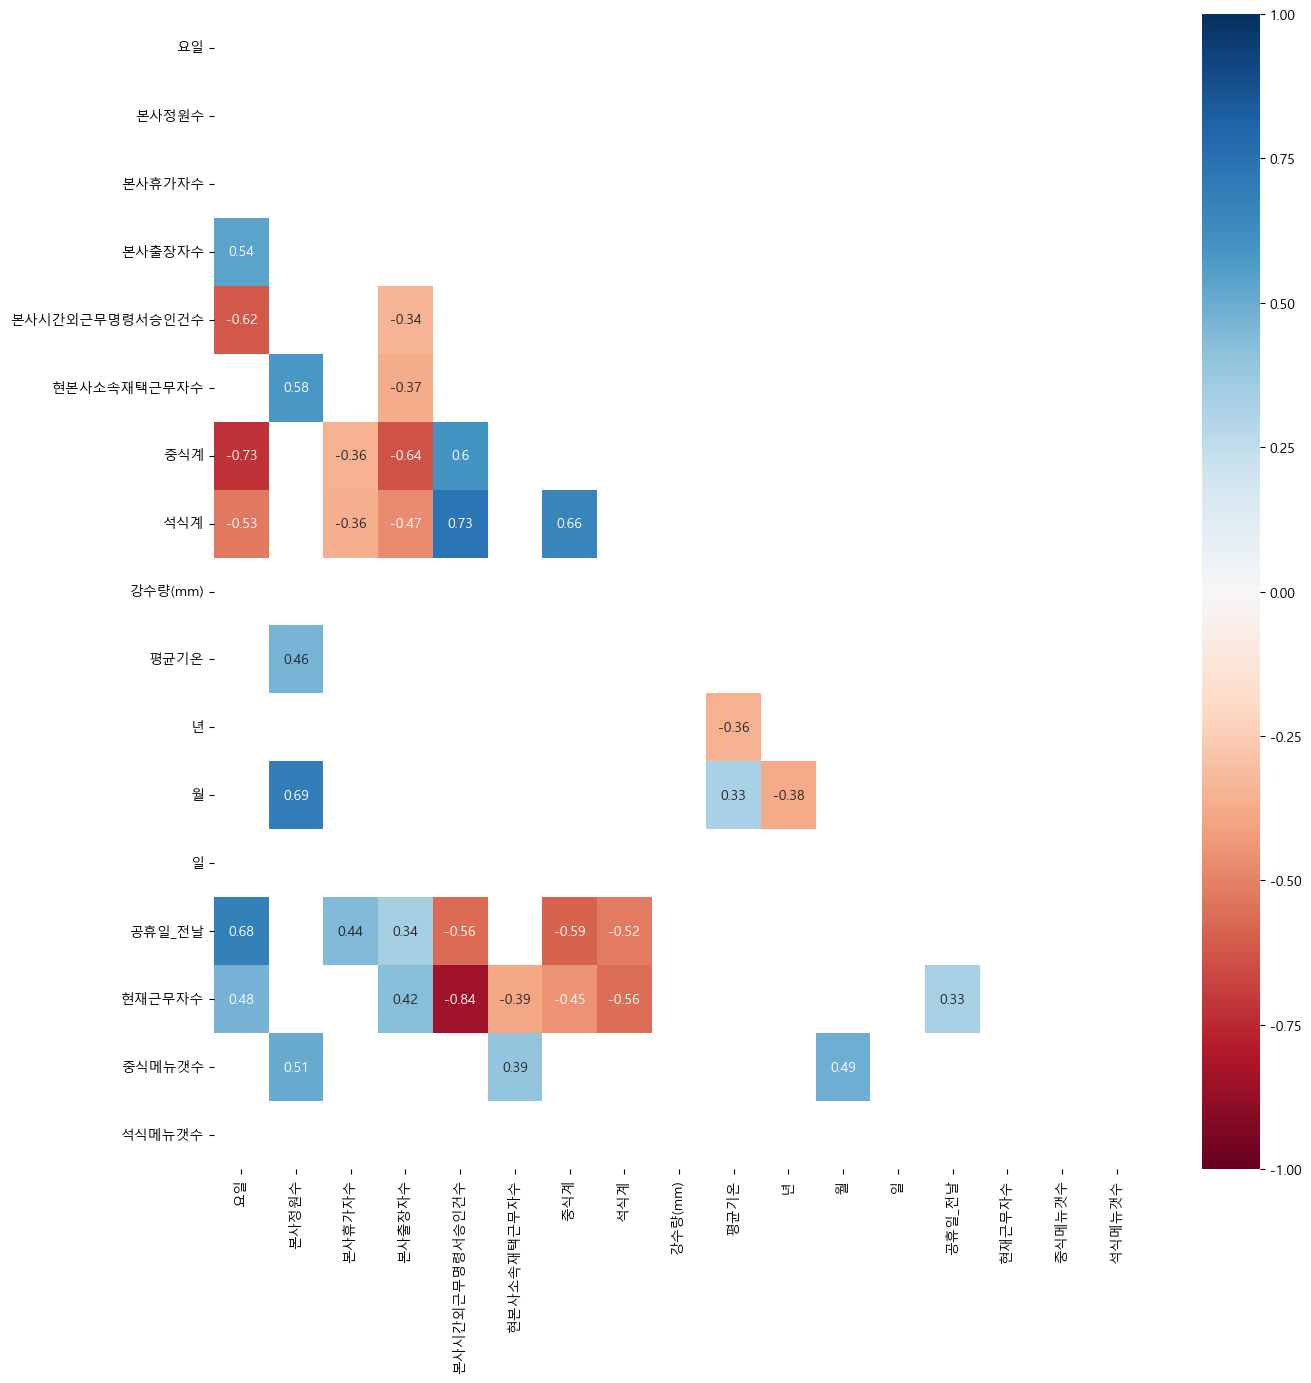

In [60]:
corr = df.corr()

mask = np.triu(np.ones_like(corr))

plt.figure(figsize = [15,15])

sns.heatmap(corr[np.abs(corr) > 0.3],mask = mask, annot = True,
            vmin = -1, vmax = 1, cmap = "RdBu")

In [61]:
회귀 = df.copy()

회귀

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,중식계,석식계,강수량(mm),...,공휴일_전날,현재근무자수,중식메뉴갯수,석식메뉴갯수,중식_밥,중식_국,중식_메인,석식_밥,석식_국,석식_메인
956,2020-01-02,3,2821,255,133,338,0.0,985.0,362.0,0.0,...,0,2095.0,7,3,쌀밥,국,돼지,특식,특식,채소
957,2020-01-03,4,2821,321,186,3,0.0,635.0,344.0,0.0,...,1,2311.0,6,6,특식,국,해산물,쌀밥,국,돼지
958,2020-01-06,0,2821,119,203,424,5.0,1133.0,389.0,13.8,...,0,2070.0,6,6,쌀밥,찌개,돼지,쌀밥,국,해산물
959,2020-01-07,1,2821,95,204,448,7.0,904.0,490.0,40.3,...,0,2067.0,6,6,쌀밥,국,닭,특식,특식,해산물
960,2020-01-08,2,2821,117,222,7,5.0,740.0,321.0,0.0,...,0,2470.0,6,6,특식,국,돼지,쌀밥,국,해산물
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1200,2021-01-20,2,2983,75,198,4,391.0,1093.0,421.0,0.0,...,0,2315.0,7,6,쌀밥,국,소,특식,특식,채소
1201,2021-01-21,3,2983,92,231,462,351.0,832.0,353.0,1.7,...,0,1847.0,7,6,쌀밥,국,해산물,특식,국,해산물
1202,2021-01-22,4,2983,255,248,1,303.0,579.0,217.0,1.2,...,1,2176.0,7,6,특식,국,닭,특식,국,돼지
1203,2021-01-25,0,2983,107,153,616,327.0,1145.0,502.0,0.0,...,0,1780.0,7,6,쌀밥,국,돼지,특식,국,해산물


In [62]:
from sklearn.linear_model import Ridge,LinearRegression
from xgboost import XGBRegressor
import xgboost
from sklearn.metrics import r2_score,mean_absolute_error
from sklearn.model_selection import train_test_split,KFold
from sklearn.tree import plot_tree

In [63]:
cols = ['중식_밥', '중식_국', '중식_메인', '석식_밥', '석식_국','석식_메인']

for col in cols:
    
    uni = df[col].unique()
    n = df[col].nunique()
    
    dicted = {}
    
    for _ in range(n):
        
        dicted[uni[_]] = _
        
    print(col,'의 변환 결과는')
    print(dicted)
    
    df[col] = df[col].map(dicted)

중식_밥 의 변환 결과는
{'쌀밥': 0, '특식': 1}
중식_국 의 변환 결과는
{'국': 0, '찌개': 1, '특식': 2, '탕': 3}
중식_메인 의 변환 결과는
{'돼지': 0, '해산물': 1, '닭': 2, '피자': 3, '오리': 4, '소': 5, '면': 6, '채소': 7, '없음': 8}
석식_밥 의 변환 결과는
{'특식': 0, '쌀밥': 1}
석식_국 의 변환 결과는
{'특식': 0, '국': 1, '찌개': 2, '탕': 3}
석식_메인 의 변환 결과는
{'채소': 0, '돼지': 1, '해산물': 2, '소': 3, '닭': 4, '없음': 5, '면': 6, '오리': 7, '피자': 8}


In [64]:
feature_name = ['요일','현재근무자수','본사휴가자수', '본사출장자수', '본사시간외근무명령서승인건수',
                '현본사소속재택근무자수', '강수량(mm)', '평균기온', '년', '월', '일', '공휴일_전날',
                '중식메뉴갯수','중식_밥', '중식_국', '중식_메인']

X = df[feature_name]
Y = df['중식계']

In [65]:
x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size = 0.2, random_state = 42)

In [66]:
parms = {'n_estimators':9999,
         'max_depth':8,
         'learning_rate':0.1,
         'objective':'reg:squarederror',
         'eval_metric':'mae',
         'early_stopping_rounds':100}

중식_모델 = XGBRegressor(**parms)

cv = KFold(n_splits = 10,shuffle = True)

scores = []
models = []
best_iteration = []

feature_importance = np.zeros(x_train.shape[1])

for i, (train_idx,valid_idx) in enumerate(cv.split(x_train,y_train)):
    
    train_x,train_y = x_train.iloc[train_idx],y_train.iloc[train_idx]
    valid_x,valid_y = x_train.iloc[valid_idx],y_train.iloc[valid_idx]
    
    중식_모델.fit(train_x,train_y,
              eval_set = [(train_x,train_y),(valid_x,valid_y)],
              verbose = 0)
    
    predict = 중식_모델.predict(valid_x)
    
    score = mean_absolute_error(valid_y,predict)
    best_iteration.append(중식_모델.best_ntree_limit)
    
    print(i+1,'번 째 MAE score :',score)
    
    feature_importance += 중식_모델.feature_importances_
    
    scores.append(score)
    models.append(중식_모델)

1 번 째 MAE score : 85.10622863769531
2 번 째 MAE score : 45.01693420410156
3 번 째 MAE score : 98.60353240966796
4 번 째 MAE score : 74.79869232177734
5 번 째 MAE score : 64.66398620605469
6 번 째 MAE score : 68.94470825195313
7 번 째 MAE score : 92.44628601074218
8 번 째 MAE score : 79.73769989013672
9 번 째 MAE score : 86.355712890625
10 번 째 MAE score : 71.70918675472862


In [67]:
print('early stopping :', best_iteration)

early stopping : [44, 46, 35, 54, 229, 43, 127, 34, 40, 77]


# Loss 값 변화

Text(0, 0.5, 'MAE')

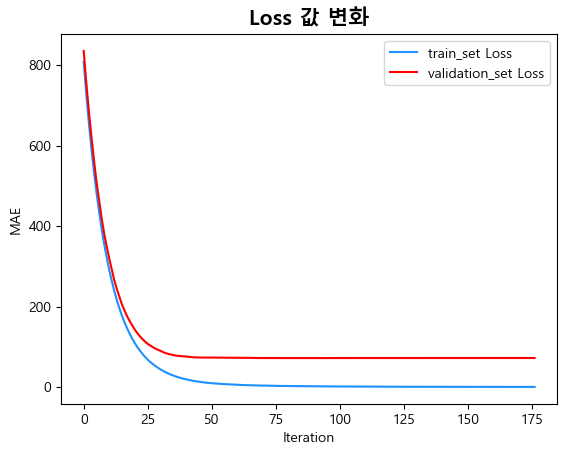

In [68]:
train_score = 중식_모델.evals_result_['validation_0']['mae']
valid_score = 중식_모델.evals_result_['validation_1']['mae']

iteration = range(len(valid_score))

plt.plot(train_score, label = 'train_set Loss', c = 'dodgerblue')
plt.plot(valid_score, label = 'validation_set Loss', c = 'red')
plt.legend()

plt.title("Loss 값 변화",weight = 'bold',fontsize = 15)
plt.xlabel('Iteration')
plt.ylabel('MAE')

# Feature Importance

Text(0.5, 0, 'Feature Importance')

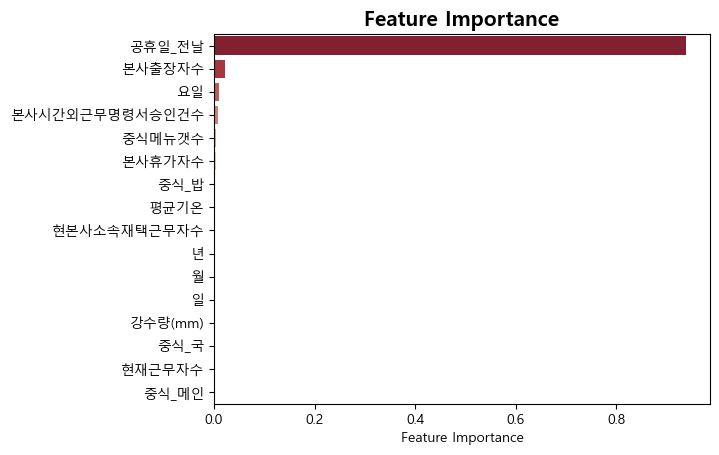

In [69]:

f_imoratonce = 중식_모델.feature_importances_

importance = pd.DataFrame({'columns':x_train.columns,
              'importance':f_imoratonce}).sort_values(by = 'importance', ascending = False)

sns.barplot(data = importance,
            x = 'importance',
            y = 'columns',
            palette = "RdBu")
plt.title('Feature Importance', fontsize = 15,weight = 'bold')
plt.ylabel('')
plt.xlabel('Feature Importance')

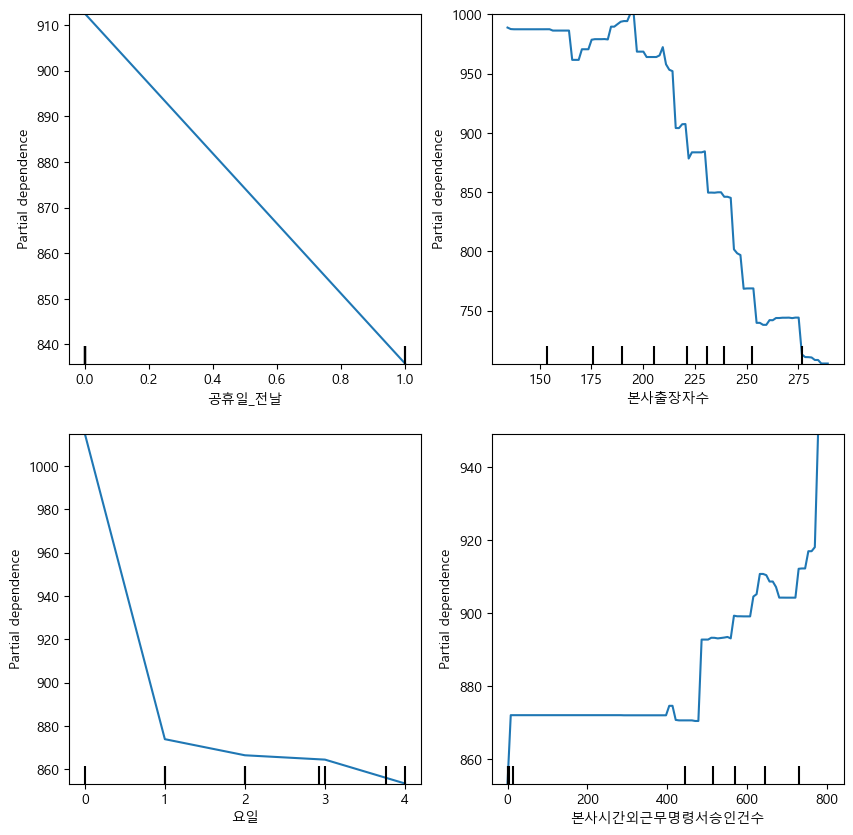

In [70]:
from sklearn.inspection import plot_partial_dependence

fig,ax = plt.subplots(ncols = 2,nrows= 2,figsize = (10,10))


ax = ax.flatten()

plot_partial_dependence(중식_모델, x_train,['공휴일_전날'],kind = 'average',target = '중식계',ax = ax[0])
plot_partial_dependence(중식_모델, x_train,['본사출장자수'],kind = 'average',target = '중식계',ax = ax[1])
plot_partial_dependence(중식_모델, x_train,['요일'],kind = 'average',target = '중식계',ax = ax[2])
plot_partial_dependence(중식_모델, x_train,['본사시간외근무명령서승인건수'],kind = 'average',target = '중식계',ax = ax[3])

In [71]:
result = np.zeros(y_test.shape[0])

for m in models:
    
    result += m.predict(x_test)
    
    
result = result / len(models)

result

array([ 648.83215332,  575.38842773,  956.24584961, 1197.68347168,
        809.39117432,  805.21173096,  682.9776001 , 1092.98999023,
        706.31311035,  690.22009277,  751.05395508, 1034.9473877 ,
        641.25360107, 1028.79284668,  933.86395264, 1308.42004395,
       1117.9197998 ,  683.75506592,  677.16107178,  671.65631104,
        687.09783936,  636.26831055, 1181.37634277,  943.35705566,
       1073.40185547, 1280.59533691, 1163.14978027,  807.32879639,
       1136.33093262,  922.01019287,  679.53656006,  819.72668457,
        834.31347656,  966.86456299, 1123.89794922,  805.75616455,
        714.42956543,  731.93218994,  631.25854492, 1259.72973633,
        590.83294678, 1173.07958984,  822.00622559,  904.03485107,
        749.40789795, 1092.04101562,  753.449646  ,  737.73382568,
        592.68847656,  978.75415039])

In [72]:
print('MAE :',mean_absolute_error(y_test,result))
print('R2 Score :',r2_score(y_test,result))

MAE : 71.3614013671875
R2 Score : 0.8334119101165556


Text(0.5, 1.0, 'XGBoost 중식계 예측 \n R2 score : 1 \n MAE : 71')

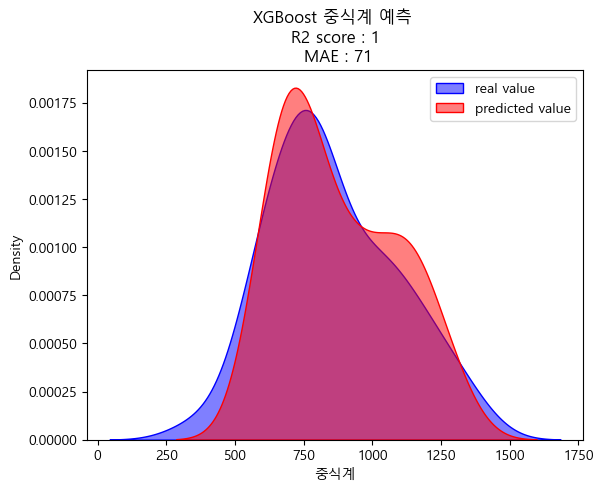

In [73]:
r2 = round(r2_score(y_test,result))
mae = round(mean_absolute_error(y_test,result))


sns.kdeplot(y_test, alpha = 0.5, color = 'blue', label = 'real value', fill = True)
sns.kdeplot(result, alpha = 0.5, color = 'red', label = 'predicted value', fill = True)
plt.legend()

plt.title(f'XGBoost 중식계 예측 \n R2 score : {r2} \n MAE : {mae}')

Text(0.5, 1.0, 'XGBoost 중식계 예측 \n R2 : 0.83 \n MAE : 71')

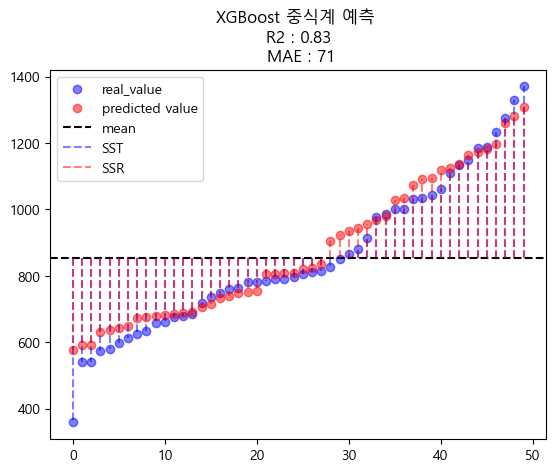

In [74]:
m = np.mean(y_test)
r2 = round(r2_score(y_test,result),2)

plt.scatter(range(len(y_test)),np.sort(y_test), label = 'real value', c = 'blue', alpha = 0.5)
plt.scatter(range(len(y_test)),np.sort(result), label = 'predicted value', c = 'red', alpha = 0.5)
plt.axhline(m, c = 'k', ls = '--', label = 'mean')



SST = np.zeros(1)
SSR = np.zeros(1)


for i in range(len(y_test)):
    
    r = np.sort(y_test)[i]
    plt.plot([i,i],[m,r], c = 'blue', alpha = 0.5, ls = '--', label = 'SST')
    
    SST += (r-m) ** 2
    
    p = np.sort(result)[i]
    plt.plot([i,i],[m,p], c = 'red', alpha = 0.5, ls = '--', label = 'SSR')
    
    SSR += (p-m) ** 2
    
    
plt.legend(['real_value','predicted value','mean','SST','SSR'])
plt.title(f'XGBoost 중식계 예측 \n R2 : {r2} \n MAE : {mae}')


In [914]:
석식데이터 = df[df['석식계'] != 0].drop(['일자','본사정원수'],axis = 1)

석식_x = 석식데이터.drop('석식계',axis = 1)
석식_y = 석식데이터['석식계']

x_train,x_test,y_train,y_test = train_test_split(석식_x,석식_y,test_size = 0.2, random_state = 77)

In [915]:
parms = {'n_estimators':9999,
         'max_depth':5,
         'learning_rate':0.05,
         'objective':'reg:squarederror',
         'eval_metric':'mae',
         'early_stopping_rounds':100}

석식_모델 = XGBRegressor(**parms)

cv = KFold(n_splits = 10,shuffle = True)

scores = []
models = []
best_iteration = []

feature_importance = np.zeros(x_train.shape[1])

for i, (train_idx,valid_idx) in enumerate(cv.split(x_train,y_train)):
    
    train_x,train_y = x_train.iloc[train_idx],y_train.iloc[train_idx]
    valid_x,valid_y = x_train.iloc[valid_idx],y_train.iloc[valid_idx]
    
    석식_모델.fit(train_x,train_y,
              eval_set = [(train_x,train_y),(valid_x,valid_y)],
              verbose = 0)
    
    predict = 석식_모델.predict(valid_x)
    
    score = mean_absolute_error(valid_y,predict)
    best_iteration.append(석식_모델.best_ntree_limit)
    
    print(i+1,'번 째 MAE score :',score)
    
    feature_importance += 석식_모델.feature_importances_
    
    scores.append(score)
    models.append(석식_모델)

1 번 째 MAE score : 55.31418304443359
2 번 째 MAE score : 40.91520690917969
3 번 째 MAE score : 52.22981567382813
4 번 째 MAE score : 56.5242919921875
5 번 째 MAE score : 42.216644287109375
6 번 째 MAE score : 65.87684936523438
7 번 째 MAE score : 31.33231715152138
8 번 째 MAE score : 39.87084639699835
9 번 째 MAE score : 24.885390432257402
10 번 째 MAE score : 49.30896558259663


Text(0, 0.5, 'MAE')

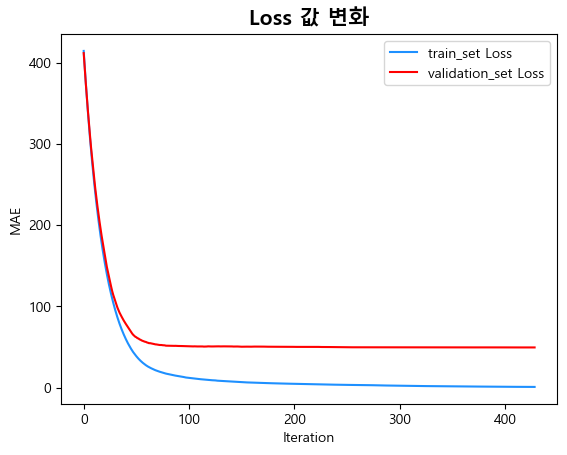

In [916]:
train_score = 석식_모델.evals_result_['validation_0']['mae']
valid_score = 석식_모델.evals_result_['validation_1']['mae']

iteration = range(len(valid_score))

plt.plot(train_score, label = 'train_set Loss', c = 'dodgerblue')
plt.plot(valid_score, label = 'validation_set Loss', c = 'red')
plt.legend()

plt.title("Loss 값 변화",weight = 'bold',fontsize = 15)
plt.xlabel('Iteration')
plt.ylabel('MAE')

Text(0.5, 0, 'Feature Importance')

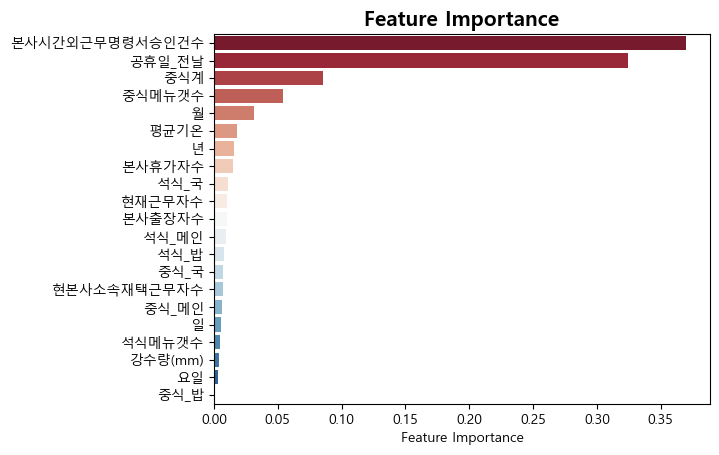

In [917]:

f_imoratonce = 석식_모델.feature_importances_

importance = pd.DataFrame({'columns':x_train.columns,
              'importance':f_imoratonce}).sort_values(by = 'importance', ascending = False)

sns.barplot(data = importance,
            x = 'importance',
            y = 'columns',
            palette = "RdBu")
plt.title('Feature Importance', fontsize = 15,weight = 'bold')
plt.ylabel('')
plt.xlabel('Feature Importance')

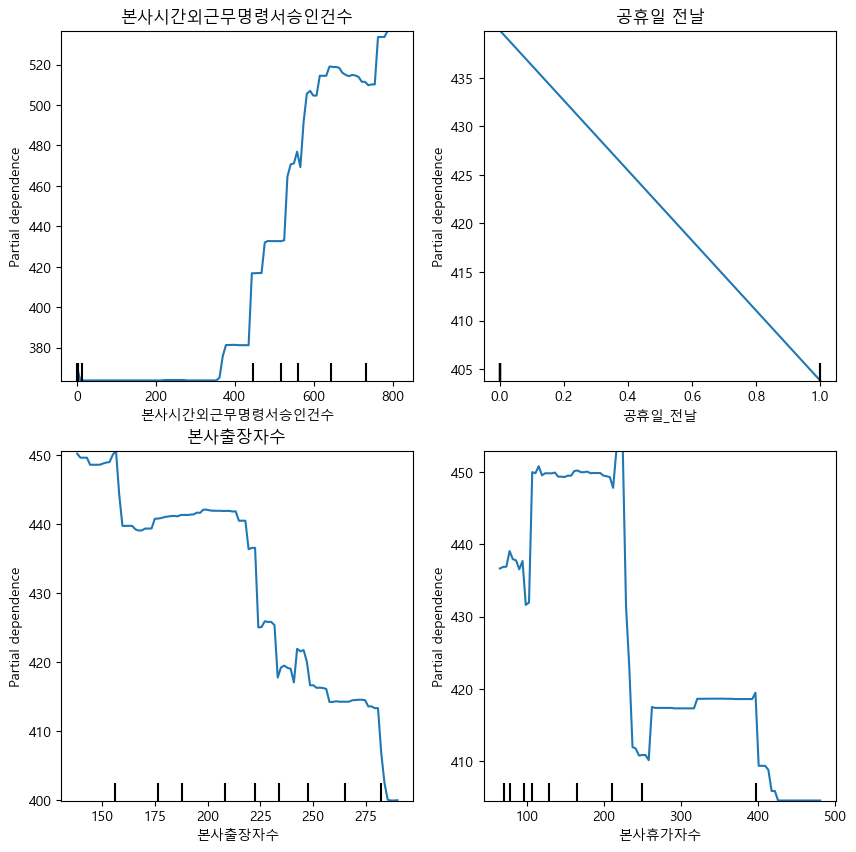

In [918]:
fig,ax = plt.subplots(ncols = 2,nrows= 2,figsize = (10,10))
cols = ['본사시간외근무명령서승인건수','공휴일 전날','본사출장자수','본사휴가자수']

ax = ax.flatten()

plot_partial_dependence(석식_모델, x_train,['본사시간외근무명령서승인건수'],kind = 'average',target = '석식계',ax = ax[0])
plot_partial_dependence(석식_모델, x_train,['공휴일_전날'],kind = 'average',target = '석식계',ax = ax[1])
plot_partial_dependence(석식_모델, x_train,['본사출장자수'],kind = 'average',target = '석식계',ax = ax[2])
plot_partial_dependence(석식_모델, x_train,['본사휴가자수'],kind = 'average',target = '석식계',ax = ax[3])

for i in range(3):
    ax[i].set_title(cols[i])

Text(0.5, 1.0, 'XGBoost 석식계 예측 \n R2 : 0.7 \n MAE : 59')

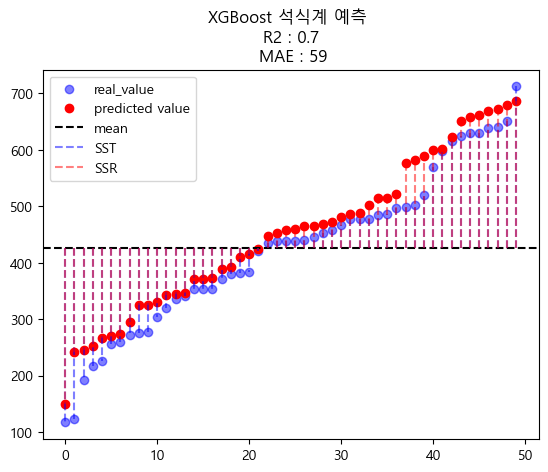

In [919]:
석식_예측 = 석식_모델.predict(x_test)

m = np.mean(y_test)

R2 = round(r2_score(y_test,석식_예측),2)
mae = round(mean_absolute_error(y_test,석식_예측))

plt.scatter(range(len(y_test)),np.sort(y_test), label = 'real value', c = 'blue', alpha = 0.5)
plt.scatter(range(len(y_test)),np.sort(석식_예측), label = 'predicted value', c = 'red')
plt.axhline(m, c = 'k', ls = '--', label = 'mean')


SST = np.zeros(1)
SSR = np.zeros(1)


for i in range(len(y_test)):
    
    r = np.sort(y_test)[i]
    plt.plot([i,i],[m,r], c = 'blue', alpha = 0.5, ls = '--', label = 'SST')
    
    SST += (r-m) ** 2
    
    p = np.sort(석식_예측)[i]
    plt.plot([i,i],[m,p], c = 'red', alpha = 0.5, ls = '--', label = 'SSR')
    
    SSR += (p-m) ** 2
    
    

plt.legend(['real_value','predicted value','mean','SST','SSR'])
plt.title(f'XGBoost 석식계 예측 \n R2 : {R2} \n MAE : {mae}')

# 중식계 다중회귀분석

In [920]:
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.preprocessing import PolynomialFeatures

In [921]:
회귀['요일'] = 회귀['요일'].map({0:'월',1:'화',2:'수',3:'목',4:'금'})

회귀.head()

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,중식계,석식계,강수량(mm),...,공휴일_전날,현재근무자수,중식메뉴갯수,석식메뉴갯수,중식_밥,중식_국,중식_메인,석식_밥,석식_국,석식_메인
956,2020-01-02,목,2821,255,133,338,0.0,985.0,362.0,0.0,...,0,2095.0,7,3,쌀밥,국,돼지,특식,특식,채소
957,2020-01-03,금,2821,321,186,3,0.0,635.0,344.0,0.0,...,1,2311.0,6,6,특식,국,해산물,쌀밥,국,돼지
958,2020-01-06,월,2821,119,203,424,5.0,1133.0,389.0,13.8,...,0,2070.0,6,6,쌀밥,찌개,돼지,쌀밥,국,해산물
959,2020-01-07,화,2821,95,204,448,7.0,904.0,490.0,40.3,...,0,2067.0,6,6,쌀밥,국,닭,특식,특식,해산물
960,2020-01-08,수,2821,117,222,7,5.0,740.0,321.0,0.0,...,0,2470.0,6,6,특식,국,돼지,쌀밥,국,해산물


In [922]:
회귀 = pd.get_dummies(회귀[['요일','공휴일_전날','본사출장자수','본사시간외근무명령서승인건수','현본사소속재택근무자수','본사휴가자수','중식계']])

회귀.head()

,공휴일_전날,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,본사휴가자수,중식계,요일_금,요일_목,요일_수,요일_월,요일_화
956,0,133,338,0.0,255,985.0,0,1,0,0,0
957,1,186,3,0.0,321,635.0,1,0,0,0,0
958,0,203,424,5.0,119,1133.0,0,0,0,1,0
959,0,204,448,7.0,95,904.0,0,0,0,0,1
960,0,222,7,5.0,117,740.0,0,0,1,0,0


In [923]:
X = 회귀[['본사시간외근무명령서승인건수','본사출장자수',
        '본사휴가자수','요일_월','공휴일_전날']] #금요일은 공휴일 전날에 포함되어 있으니 제거하자
Y = 회귀['중식계']

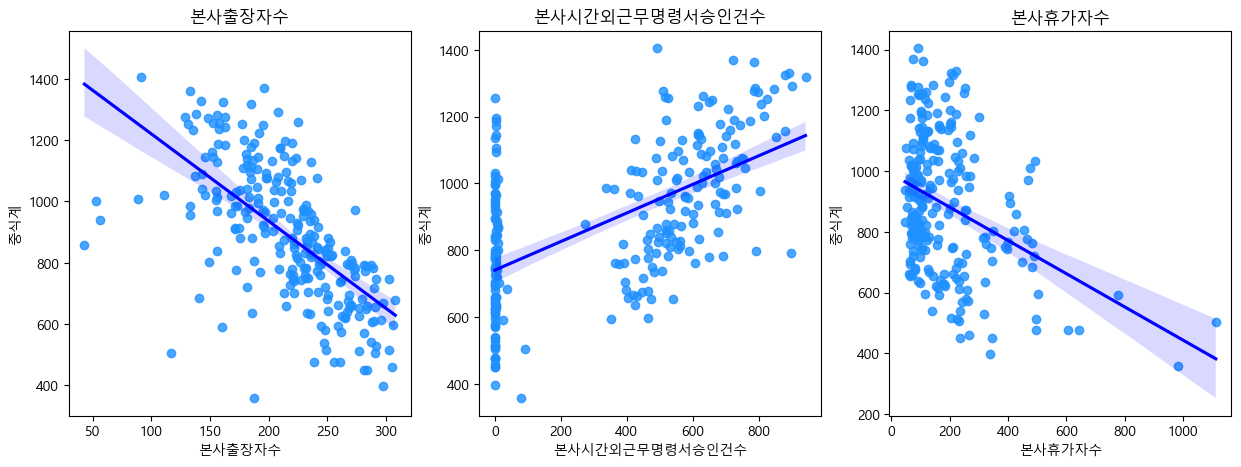

In [924]:
cols = ['본사출장자수','본사시간외근무명령서승인건수','본사휴가자수']

plt.figure(figsize = [15,5])

for i,col in enumerate(cols):
    
    plt.subplot(1,3,i+1)
    
    sns.regplot(X[col], Y,
                scatter_kws = {'color':'dodgerblue'},
                line_kws = {'color':'blue'})
    plt.title(col)
    

Text(0.5, 1.0, '중식계 상관관계')

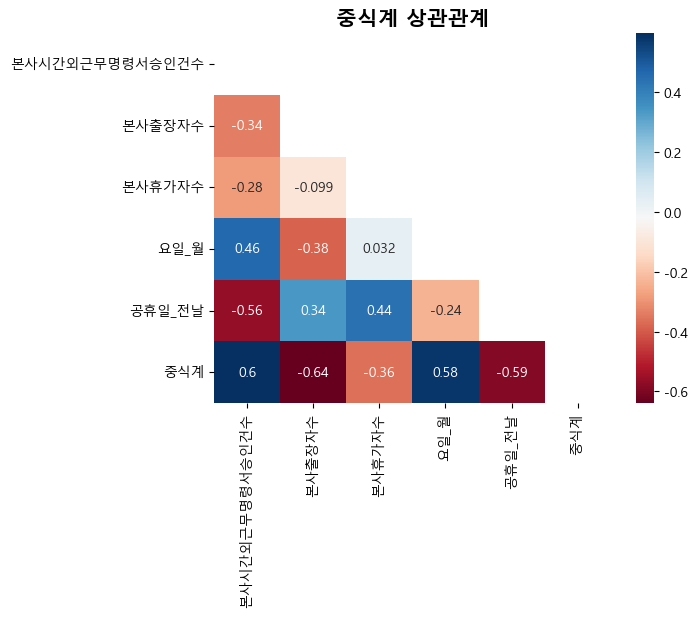

In [925]:
corr = X.join(Y).corr()

mask = np.triu(np.ones_like(corr))

sns.heatmap(corr, mask = mask, cmap = 'RdBu', annot = True)
plt.title('중식계 상관관계', weight = 'bold', fontsize = 15)

In [926]:
x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size = 0.2,random_state = 77)

# 점수비교

In [927]:
linear = LinearRegression()
ridge = Ridge(alpha = 0.5)
lasso = Lasso(alpha = 0.5)

linear.fit(x_train,y_train)
ridge.fit(x_train,y_train)
lasso.fit(x_train,y_train)

linear_pred = linear.predict(x_test)
linear_resid = y_test - linear_pred

ridge_pred = ridge.predict(x_test)
ridge_resid = y_test - ridge_pred

lasso_pred = lasso.predict(x_test)
lasso_resid = y_test - lasso_pred

In [928]:
print('OLS')
print('Train set 에 대한 점수:', r2_score(y_train,linear.predict(x_train)))
print('test set 에 대한 점수:', r2_score(y_test,linear.predict(x_test)))
print('--'*20)
print('RIDGE')
print('Train set 에 대한 점수:', r2_score(y_train,ridge.predict(x_train)))
print('test set 에 대한 점수:', r2_score(y_test,ridge.predict(x_test)))
print('--'*20)
print('LASSO')
print('Train set 에 대한 점수:', r2_score(y_train,lasso.predict(x_train)))
print('test set 에 대한 점수:', r2_score(y_test,lasso.predict(x_test)))

OLS
Train set 에 대한 점수: 0.7418768649893954
test set 에 대한 점수: 0.7775910833854478
----------------------------------------
RIDGE
Train set 에 대한 점수: 0.7418345172714661
test set 에 대한 점수: 0.7771569547971
----------------------------------------
LASSO
Train set 에 대한 점수: 0.7417758594550277
test set 에 대한 점수: 0.7760829536826119


In [929]:
회귀식 = [ridge.intercept_] + ridge.coef_.tolist()
열 = ['절편'] + x_train.columns.tolist()

회귀계수 = pd.DataFrame({'열' : 열,
        '회귀식':회귀식})

회귀계수

,열,회귀식
0,절편,1339.812888
1,본사시간외근무명령서승인건수,0.093408
2,본사출장자수,-1.950902
3,본사휴가자수,-0.477853
4,요일_월,175.971749
5,공휴일_전날,-66.940526


In [930]:
요일 = 회귀계수[회귀계수['열'].str.contains('일')]
회사정보 = 회귀계수.drop(index = 요일.index, axis = 0).iloc[1:]

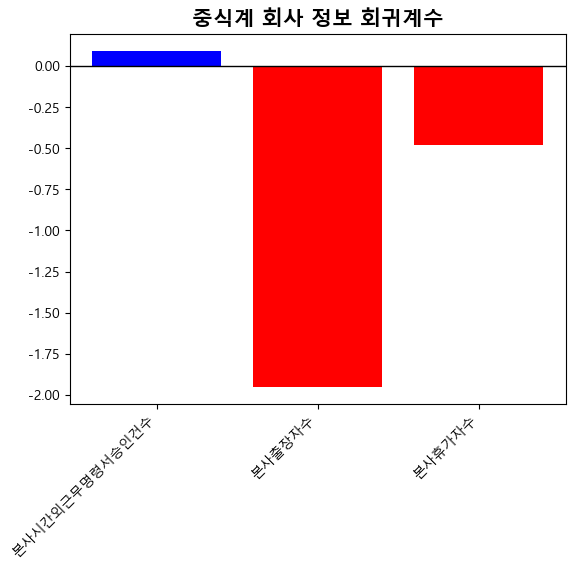

In [931]:
fig, ax = plt.subplots()


x = 회사정보['열']
y = 회사정보['회귀식']

color_map = ['red' if i < 0 else 'blue' for i in y]

ax.bar(x, y, color=color_map)
ax.axhline(0, c = 'k', lw = 1)
ax.set_title('중식계 회사 정보 회귀계수', weight = 'bold', fontsize = 15)

# x축 라벨 회전
plt.xticks(rotation=45, ha='right')

plt.show()


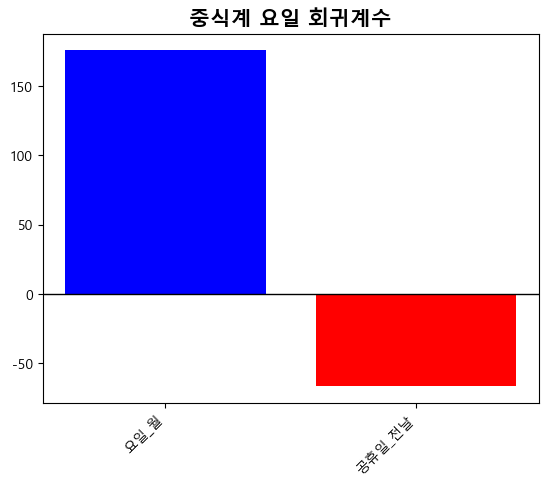

In [932]:
fig, ax = plt.subplots()


x = 요일['열']
y = 요일['회귀식']

color_map = ['red' if i < 0 else 'blue' for i in y]

ax.bar(x, y, color=color_map)
ax.axhline(0, c = 'k', lw = 1)
ax.set_title('중식계 요일 회귀계수',weight = 'bold', fontsize = 15)
# x축 라벨 회전
plt.xticks(rotation=45, ha='right')

plt.show()

Text(0.5, 1.0, '다중회귀분석 중식계 예측 \n R2 : 0.78 \n MAE : 77')

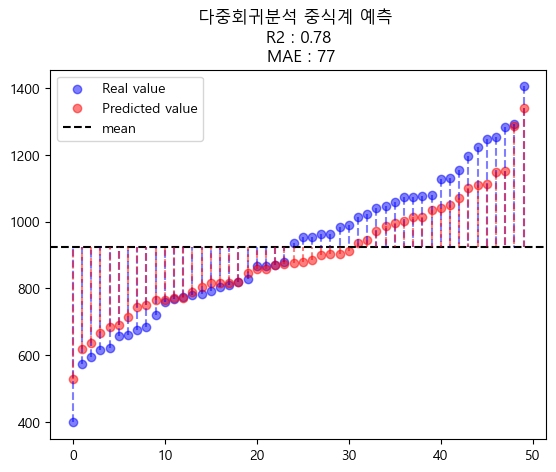

In [933]:
ridge_predicted = sorted(ridge.predict(x_test))
m = np.mean(y_test)
n = range(len(y_test))
mae = round(mean_absolute_error(y_test,ridge.predict(x_test)))
r2 = round(r2_score(y_test,ridge.predict(x_test)),2)


plt.scatter(n,sorted(y_test),c = 'blue', alpha = 0.5, label = 'Real value')
plt.scatter(n,ridge_predicted, c = 'red', alpha = 0.5,label = 'Predicted value')
plt.axhline(m, c = 'k', ls = '--', label = 'mean')

SST = 0

for i in n:
    
    r = sorted(y_test)[i]
    
    plt.plot([i,i],[r,m], color ='blue', alpha=0.5, ls='--', label='SST')
    
    SST += (r-m)**2
    
SSR = 0
    
for i in n:
    
    p = ridge_predicted[i]
    
    plt.plot([i,i],[p,m], color ='red', alpha=0.5, ls='--',label='SSR')

    SSR += (p-m)**2 


plt.legend(['Real value','Predicted value','mean'])
plt.title(f'다중회귀분석 중식계 예측 \n R2 : {r2} \n MAE : {mae}')

# 석식계 예측

In [934]:
cols = ['요일', '본사휴가자수', '본사출장자수', '본사시간외근무명령서승인건수',
       '현본사소속재택근무자수', '중식계','공휴일_전날','석식메뉴갯수',
       '현재근무자수','석식계']

석식 = df[cols].copy()

X = 석식[석식['석식계'] != 0]
X['요일'] = X['요일'].map({0:'월',1:'화',2:'수',3:'목',4:'금'})

In [935]:
X = pd.get_dummies(X)

X = X[['본사휴가자수', '본사출장자수', '본사시간외근무명령서승인건수', '현본사소속재택근무자수', '공휴일_전날','석식메뉴갯수', '요일_월']]
X

,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,공휴일_전날,석식메뉴갯수,요일_월
956,255,133,338,0.0,0,3,0
957,321,186,3,0.0,1,6,0
958,119,203,424,5.0,0,6,1
959,95,204,448,7.0,0,6,0
960,117,222,7,5.0,0,6,0
...,...,...,...,...,...,...,...
1200,75,198,4,391.0,0,6,0
1201,92,231,462,351.0,0,6,0
1202,255,248,1,303.0,1,6,0
1203,107,153,616,327.0,0,6,1


In [936]:
Y = 석식.loc[석식['석식계'] != 0, '석식계']

In [937]:
x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size = 0.2, random_state = 42)

In [938]:
linear = LinearRegression()
ridge = Ridge(alpha = 0.1)
lasso = Lasso(alpha = 0.1)

linear.fit(x_train,y_train)
ridge.fit(x_train,y_train)
lasso.fit(x_train,y_train)

linear_pred = linear.predict(x_test)
linear_resid = y_test - linear_pred

ridge_pred = ridge.predict(x_test)
ridge_resid = y_test - ridge_pred

lasso_pred = lasso.predict(x_test)
lasso_resid = y_test - lasso_pred

In [939]:
print('OLS')
print('Train set 에 대한 점수:', r2_score(y_train,linear.predict(x_train)))
print('test set 에 대한 점수:', r2_score(y_test,linear.predict(x_test)))
print('--'*20)
print('RIDGE')
print('Train set 에 대한 점수:', r2_score(y_train,ridge.predict(x_train)))
print('test set 에 대한 점수:', r2_score(y_test,ridge.predict(x_test)))
print('--'*20)
print('LASSO')
print('Train set 에 대한 점수:', r2_score(y_train,lasso.predict(x_train)))
print('test set 에 대한 점수:', r2_score(y_test,lasso.predict(x_test)))

OLS
Train set 에 대한 점수: 0.6768349962911823
test set 에 대한 점수: 0.7298112966812492
----------------------------------------
RIDGE
Train set 에 대한 점수: 0.6768349599528563
test set 에 대한 점수: 0.7298325584760812
----------------------------------------
LASSO
Train set 에 대한 점수: 0.6768184282490507
test set 에 대한 점수: 0.7300458487556231


In [940]:
회귀식 = [lasso.intercept_] + lasso.coef_.tolist()
열 = ['절편'] + x_train.columns.tolist()

회귀계수 = pd.DataFrame({'열' : 열,
        '회귀식':회귀식})

회귀계수

,열,회귀식
0,절편,556.946845
1,본사휴가자수,-0.242968
2,본사출장자수,-0.964927
3,본사시간외근무명령서승인건수,0.216486
4,현본사소속재택근무자수,-0.060833
5,공휴일_전날,-5.194832
6,석식메뉴갯수,10.386367
7,요일_월,9.266545


In [941]:
요일 = 회귀계수[회귀계수['열'].str.contains('일')]
회사정보 = 회귀계수.drop(index = 요일.index, axis = 0).iloc[1:]

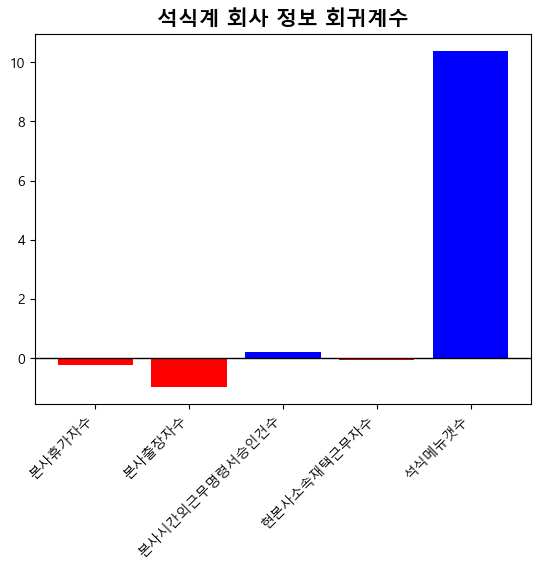

In [942]:
fig, ax = plt.subplots()


x = 회사정보['열']
y = 회사정보['회귀식']

color_map = ['red' if i < 0 else 'blue' for i in y]

ax.bar(x, y, color=color_map)
ax.axhline(0, c = 'k', lw = 1)
ax.set_title('석식계 회사 정보 회귀계수', weight = 'bold', fontsize = 15)

# x축 라벨 회전
plt.xticks(rotation=45, ha='right')

plt.show()


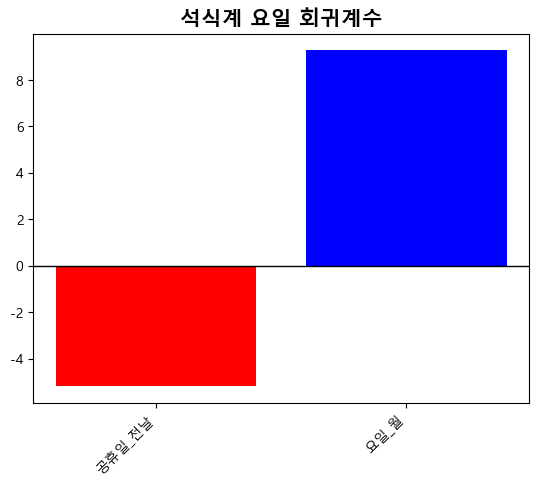

In [943]:
fig, ax = plt.subplots()


x = 요일['열']
y = 요일['회귀식']

color_map = ['red' if i < 0 else 'blue' for i in y]

ax.bar(x, y, color=color_map)
ax.axhline(0, c = 'k', lw = 1)
ax.set_title('석식계 요일 회귀계수',weight = 'bold', fontsize = 15)
# x축 라벨 회전
plt.xticks(rotation=45, ha='right')

plt.show()

Text(0.5, 1.0, '다중회귀분석 석식계 예측 \n R2 : 0.73')

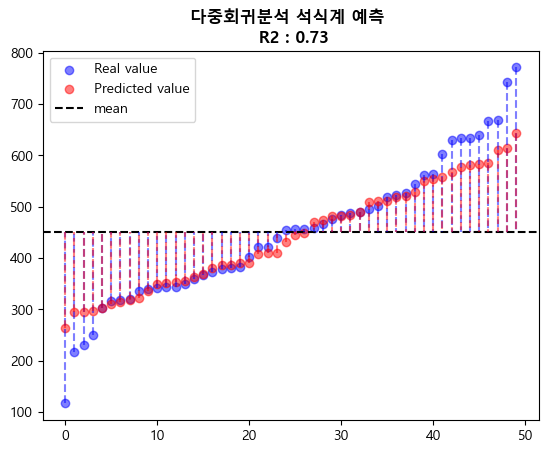

In [954]:
lasso_predicted = sorted(lasso.predict(x_test))
m = np.mean(y_test)
n = range(len(y_test))
mae = mean_absolute_error(y_test,lasso_predicted)
r2 = round(r2_score(y_test,lasso.predict(x_test)),2)


plt.scatter(n,sorted(y_test),c = 'blue', alpha = 0.5, label = 'Real value')
plt.scatter(n,lasso_predicted, c = 'red', alpha = 0.5,label = 'Predicted value')
plt.axhline(m, c = 'k', ls = '--', label = 'mean')

SST = 0

for i in n:
    
    r = sorted(y_test)[i]
    
    plt.plot([i,i],[r,m], color ='blue', alpha=0.5, ls='--', label='SST')
    
    SST += (r-m)**2
    
SSR = 0
    
for i in n:
    
    p = lasso_predicted[i]
    
    plt.plot([i,i],[p,m], color ='red', alpha=0.5, ls='--',label='SSR')

    SSR += (p-m)**2 


plt.legend(['Real value','Predicted value','mean'])
plt.title(f'다중회귀분석 석식계 예측 \n R2 : {r2}',
          weight = 'bold')